# 机器学习练习 1 - 多变量线性回归

## 1.训练数据基本操作

- 已知房屋的大小，和房间数量来预测房价，历史样本文件如`multi_variable_linear_regression.txt`

### 1.1 加载训练样本文件，看数据特性

In [55]:
import math, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
def load_data(filename):
    """
    从CSV文件加载数据集
    参数:
        filename (str): 数据文件绝对路径
    返回:
        X (ndarray): (m, n) 特征矩阵 
        y (ndarray): (m,) 目标向量
    """
    data = pd.read_csv(filename, header=None, names=['Size', 'Bedrooms', 'Price'])
    X = data.iloc[:, :-1].values  # 前n列为特征
    y = data.iloc[:, -1].values   # 最后一列为目标值
    return X, y, data

In [57]:
X, y, data = load_data('./multi_variable_linear_regression.txt')

In [58]:
# 查看文件头,默认展示前5行
data.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [59]:
# 查看数据详情格式
data.describe()

,Size,Bedrooms,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


In [60]:
X.shape

(47, 2)

In [61]:
y.shape

(47,)

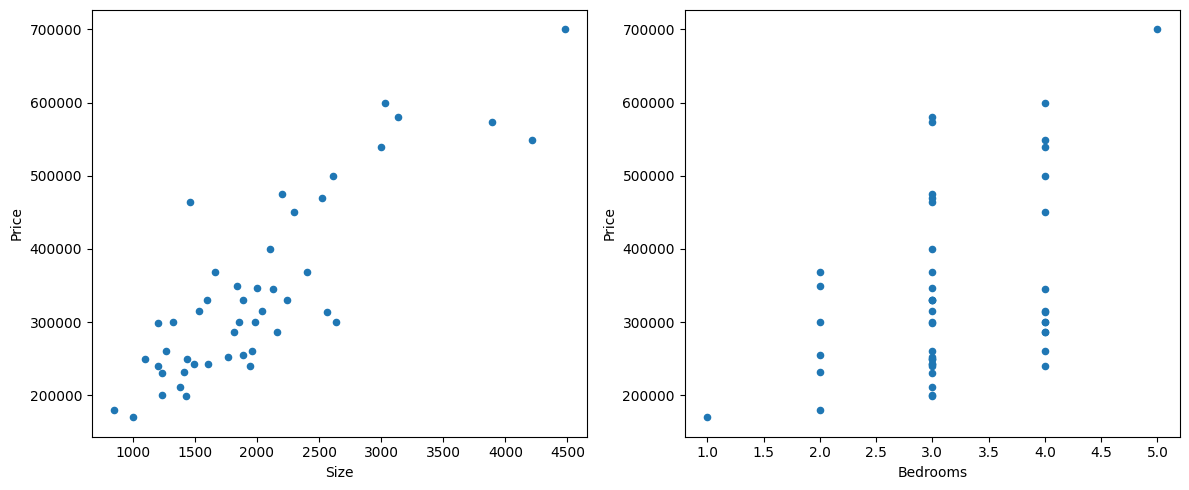

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
data.plot.scatter(x='Size', y='Price', ax=axes[0])
data.plot.scatter(x='Bedrooms', y='Price', ax=axes[1])
plt.tight_layout()
plt.show()

- 通过上述样本特性不难看出，其中Size和Bedrooms的数据特性差异较大，需要做归一化处理

### 1.2 Zscore 对样本进行归一化处理

**Z-Score归一化方程**

**对每个特征列的标准化计算：**
$$ x^{(i)}_j = \frac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{1-1} $$ 

其中：
- 均值计算（特征j的均值）：
  $$ \mu_j = \frac{1}{m} \sum_{i=1}^m x^{(i)}_j \tag{1-2}$$
  
- 标准差计算（特征j的标准差）：
  $$ \sigma_j = \sqrt{\frac{1}{m} \sum_{i=1}^m \left( x^{(i)}_j - \mu_j \right)^2 } \tag{1-3}$$

**Z-Score归一化方程（矩阵形式）**
$$ \mathbf{X}_{norm} = (\mathbf{X} - \mathbf{\mu}) \oslash \mathbf{\sigma} \tag{1-4}$$

其中：
- $\mathbf{\mu} = \frac{1}{m} \mathbf{1}^T \mathbf{X} \in \mathbb{R}^{1 \times n}$（行向量）  
- $\mathbf{\sigma} = \sqrt{\frac{1}{m} \sum_{i=1}^m (\mathbf{X} - \mathbf{\mu}) \odot (\mathbf{X} - \mathbf{\mu})} \in \mathbb{R}^{1 \times n}$  
- $\oslash$ 表示逐元素除法

**参数反向转换:**
$$ \mathbf{w}^{original} = \mathbf{w}^{norm} \oslash \mathbf{\sigma} \tag{1-5}$$
$$ b^{original} = b^{norm} - \mathbf{\mu}^T (\mathbf{w}^{norm} \oslash \mathbf{\sigma}) \tag{1-6}$$

**维度验证：**
$$ \underset{n \times 1}{\mathbf{w}^{original}} = \underset{n \times 1}{\mathbf{w}^{norm}} \oslash \underset{n \times 1}{\mathbf{\sigma}^T} $$

**定义函数如下：**

In [63]:
def zscore_normalize(X):
    """
    Z-Score标准化
    参数:
        X (ndarray): (m, n)原始特征矩阵
    返回:
        X_norm (ndarray): (m, n)标准化后矩阵
        μ (ndarray): (n,)特征均值向量
        σ (ndarray): (n,)特征标准差向量
    """
    μ = np.mean(X, axis=0, keepdims=True)  # 保持二维结构
    σ = np.std(X, axis=0, keepdims=True)
    X_norm = (X - μ) / σ
    return X_norm, μ.flatten(), σ.flatten()  # 转换为一维

In [64]:
X_norm, X_μ, X_σ = zscore_normalize(X)

In [65]:
print(X_norm)

[[ 1.31415422e-01 -2.26093368e-01]
 [-5.09640698e-01 -2.26093368e-01]
 [ 5.07908699e-01 -2.26093368e-01]
 [-7.43677059e-01 -1.55439190e+00]
 [ 1.27107075e+00  1.10220517e+00]
 [-1.99450507e-02  1.10220517e+00]
 [-5.93588523e-01 -2.26093368e-01]
 [-7.29685755e-01 -2.26093368e-01]
 [-7.89466782e-01 -2.26093368e-01]
 [-6.44465993e-01 -2.26093368e-01]
 [-7.71822042e-02  1.10220517e+00]
 [-8.65999486e-04 -2.26093368e-01]
 [-1.40779041e-01 -2.26093368e-01]
 [ 3.15099326e+00  2.43050370e+00]
 [-9.31923697e-01 -2.26093368e-01]
 [ 3.80715024e-01  1.10220517e+00]
 [-8.65782986e-01 -1.55439190e+00]
 [-9.72625673e-01 -2.26093368e-01]
 [ 7.73743478e-01  1.10220517e+00]
 [ 1.31050078e+00  1.10220517e+00]
 [-2.97227261e-01 -2.26093368e-01]
 [-1.43322915e-01 -1.55439190e+00]
 [-5.04552951e-01 -2.26093368e-01]
 [-4.91995958e-02  1.10220517e+00]
 [ 2.40309445e+00 -2.26093368e-01]
 [-1.14560907e+00 -2.26093368e-01]
 [-6.90255715e-01 -2.26093368e-01]
 [ 6.68172729e-01 -2.26093368e-01]
 [ 2.53521350e-01 -2

In [66]:
print(X_μ)

[2000.68085106    3.17021277]


In [67]:
print(X_σ)

[7.86202619e+02 7.52842809e-01]


## 2. 线性回归模型介绍

### 2.1 线性回归方程

**单变量线性回归方程标量形式**

$$f_{{w},b}({x}) = {w} \cdot {x} + b \tag{2-1}$$

其中:
- w: 权重（斜率）
- b: 偏置（截距）
- x: 输入特征（单变量）

**多变量线性回归方程向量形式：**

$$ f(\mathbf{w},b) = \mathbf{w}^T \mathbf{x} + b \tag{2-2}$$

其中：
- $\mathbf{w} \in \mathbb{R}^{n \times 1}$ 为权重列向量  
- $\mathbf{x} \in \mathbb{R}^{n \times 1}$ 为单个样本的特征向量  
- $b \in \mathbb{R}$ 为标量偏置项

假设有 n 个特征，每个样本的特征向量为$\mathbf{x} = \begin{bmatrix} x_1 & x_2 & x_3 \dots x_n \end{bmatrix}$, 权重向量$\mathbf{w} = \begin{bmatrix} w_1 & w_2 & w_3 \dots \end{bmatrix}^T$,偏置为b。将偏置b合并到权重向量中，并添加一个值为 1 的虚拟特征到样本输入矩阵

对m个样本，每个样本扩展为$\mathbf{x}^{(i)} = \begin{bmatrix} 1 & x_1^{(i)} & x_2^{(i)} \dots x_n^{(i)} \end{bmatrix}$

对应的扩展X矩阵为：
$$\mathbf{X} = 
\begin{bmatrix} 
    \mathbf{x}^{(1)} \\
    \mathbf{x}^{(2)} \\
    \vdots \\
    \mathbf{x}^{(n)} \\
\end{bmatrix} \\
= \\ 
\begin{bmatrix} 
    1 & x_1^{(1)} & x_2^{(1)} & \cdots & x_n^{(1)} \\ 
    1 & x_1^{(2)} & x_2^{(2)} & \cdots & x_n^{(2)} \\ 
    \vdots & \vdots & \vdots & \ddots & \vdots \\ 
    1 & x_1^{(m)} & x_2^{(m)} & \cdots & x_n^{(m)} 
\end{bmatrix}
$$

扩展权重向量$\mathbf{\theta}$为:

$$
\mathbf{\theta} = \begin{bmatrix}
b \\
w_1 \\
w_2 \\
\vdots \\
w_n
\end{bmatrix}
$$

**回归方程（增广矩阵形式）**

$$ \mathbf{\hat{y}} = f_\mathbf{\theta}(\mathbf{X})= \mathbf{X} \mathbf{\theta} \tag{2-3}$$

其中：
- $\mathbf{X} = [\mathbf{1} \quad \mathbf{X}_{原始}] \in \mathbb{R}^{m \times (n+1)}$（添加全1列的增广矩阵）  
- $\mathbf{\theta} = \begin{bmatrix} b \\ \mathbf{w} \end{bmatrix} \in \mathbb{R}^{(n+1) \times 1}$

### 2.2 cost function 成本函数

**标量形式的MSE定义**

对于 m 个样本和 n 个特征，标量形式的均方误差为：
$$ J(\mathbf{\theta}) = \frac{1}{2m} \sum_{i=1}^m \left( \mathbf{w}^T \mathbf{x}^{(i)} + b - y^{(i)} \right)^2 \tag{2-4}$$

结合公式2-3 均方误差（MSE）定义为：

$$J(\mathbf{\theta}) = \frac{1}{2m} \cdot \sum\limits_{i = 1}^{m} (f_{\mathbf{\theta}}(\mathbf{X}^{(i)}) - y^{(i)})^2 \tag{2-5}$$ 

定义误差向量
$ \mathbf{\epsilon} = \mathbf{X}\mathbf{\theta} - \mathbf{y} $

将其代入到公式(2-5)
$$J(\mathbf{\theta}) = \frac{1}{2m} \cdot \sum\limits_{i = 1}^{m} \mathbf{\epsilon}_{(i)}^2 \tag{2-6}$$ 

标量形式的平方和可等价表示为：
$$ 
\sum_{i=1}^m \epsilon_i^2 = 
\epsilon^T \epsilon = 
\begin{bmatrix}
    \epsilon_1 \\
    \vdots \\
    \epsilon_n
\end{bmatrix}  \times 
\begin{bmatrix} 
    \epsilon_1 & 
    \dots 
    \epsilon_n 
\end{bmatrix}
\tag{2-7}
$$

代入误差向量可得到：
$$ \sum_{i=1}^m \epsilon_i^2 = (\mathbf{X}\mathbf{\theta} - \mathbf{y})^T (\mathbf{X}\mathbf{\theta} - \mathbf{y}) \tag{2-8}$$

**矩阵形式MSE** 
 - 将平方和(2-8)代入标量形式MSE(2-4 或 2-5)：
$$ J(\mathbf{\theta}) = \frac{1}{2m} (\mathbf{X}\mathbf{\theta} - \mathbf{y})^T (\mathbf{X}\mathbf{\theta} - \mathbf{y}) \tag{2-9}$$

### 2.3. 成本函数的偏导（矩阵形式）

#### 2.3.1 展开$J(\mathbf{\theta})$,并对其简化**

首先展开公式$J(\theta)$ 公式（2-9）:
$$
J(\mathbf{\theta}) = \frac{1}{2m} 
(
\begin{aligned}
\mathbf{\theta}^T \mathbf{X}^T \mathbf{X}\mathbf{\theta} - \mathbf{\theta}^T \mathbf{X}^T \mathbf{y} - \mathbf{y}^T \mathbf{X}\mathbf{\theta} + \mathbf{y}^T \mathbf{y}
\end{aligned}
)
\tag{2-10}
$$

由于标量的转置等于自身,对其转换有：
$$
\mathbf{y}^T \mathbf{X}\mathbf{\theta} = (\mathbf{X}\mathbf{\theta})^T \mathbf{y} = \mathbf{\theta}^T \mathbf{X}^T \mathbf{y} \tag{2-11}
$$

从而得到：
$$ 
-\mathbf{\theta}^T \mathbf{X}^T \mathbf{y} - \mathbf{y}^T \mathbf{X}\mathbf{\theta} = -2\mathbf{\theta}^T \mathbf{X}^T \mathbf{y} \tag{2-12}
$$

最后得到：
$$ 
J(\mathbf{\theta}) = \frac{1}{2m} \left( \mathbf{\theta}^T \mathbf{X}^T \mathbf{X}\mathbf{\theta} - 2\mathbf{\theta}^T \mathbf{X}^T \mathbf{y} + \mathbf{y}^T \mathbf{y} \right) \tag{2-13}
$$

#### 2.3.2 基于公式(2-13)对$\theta$求偏导
- 可参考[合集·【矩阵的导数运算】_DR_CAN合集][链接标识]

[链接标识]: https://space.bilibili.com/230105574/lists/1814753?type=season

**(1)线性项求导规则**
$$
\frac{\partial}{\partial \mathbf{\theta}} \left( \mathbf{B}\mathbf{\theta} \right) = \mathbf{B}^T \tag{2-14}
$$

- $\mathbf{B}$为矩阵
- $\mathbf{\theta}$ 为向量

**(2)二次型求导规则**
$$
\frac{\partial}{\partial \mathbf{\theta}} \left( \mathbf{\theta}^T \mathbf{A} \mathbf{\theta} \right) = \mathbf{A}\mathbf{\theta} + \mathbf{A}^T\mathbf{\theta} \tag{2-15}
$$

- 其中$\mathbf{A}为矩阵$
- 并且当$\mathbf{A}$为对称矩阵时有：

$$
\frac{\partial}{\partial \mathbf{\theta}} \left( \mathbf{\theta}^T \mathbf{A} \mathbf{\theta} \right) = 2\mathbf{A}\mathbf{\theta} \tag{2-16}
$$

**(3) 对公式2-13进行逐项求导**

- ​**第一项**​：该步骤将$\mathbf{X}^T \mathbf{X} 看成\mathbf{A} 并且一定是一个对称矩阵 (根据2-15和2-16) 有$
$$ 
\frac{\partial}{\partial \mathbf{\theta}} (\mathbf{\theta}^T \mathbf{X}^T \mathbf{X}\mathbf{\theta}) = 2\mathbf{X}^T \mathbf{X}\mathbf{\theta}
\tag{2-17}
$$
- ​**第二项**​：(根据2-14) 有
$$ 
\frac{\partial}{\partial \mathbf{\theta}} (-2\mathbf{\theta}^T \mathbf{X}^T \mathbf{y}) = 
\frac{\partial}{\partial \mathbf{\theta}} (-2\mathbf{\theta} (\mathbf{X}^T \mathbf{y})^T) =
-2\mathbf{X}^T \mathbf{y}
\tag{2-18}
$$

- ​**第三项**​：
$$ 
\frac{\partial}{\partial \mathbf{\theta}} (\mathbf{y}^T \mathbf{y}) = \mathbf{0}
\tag{2-19}
$$

**(4) 结合公式2-17~2-19可得到$\nabla_{\mathbf{\theta}} J$:**
$$ 
\nabla_{\mathbf{\theta}} J = 
\frac{\partial J}{\partial \mathbf{\theta}} =
\frac{1}{2m} 
\left( 
    2\mathbf{X}^T \mathbf{X}\mathbf{\theta} -2\mathbf{X}^T \mathbf{y} 
\right) = 
\frac{1}{m} \mathbf{X}^T 
\left(
    \mathbf{X}\mathbf{\theta} - \mathbf{y}
\right)
\tag{2-20}
$$

### 2.4. 梯度下降（矩阵形式）

更新规则:
$$ \mathbf{\theta} := \mathbf{\theta} - \alpha \nabla_{\mathbf{\theta}} J \tag{2-21}$$

 - 其中$ \alpha: 学习率（步长）$

## 3 实现数据训练

In [68]:
def compute_cost(X, y, theta):
    """
    计算线性回归成本函数
    参数:
        X (ndarray): (m, n+1)增广特征矩阵
        y (ndarray): (m,)目标向量
        theta (ndarray): (n+1,)参数向量 [b, w1, w2,...wn]^T
    返回:
        J (float): 成本函数值
    """
    m = X.shape[0]
    error = X @ theta - y
    return (error.T @ error) / (2 * m)

In [69]:
def compute_gradient(X, y, theta):
    """
    计算参数梯度
    参数:
        X (ndarray): (m, n+1)增广特征矩阵
        y (ndarray): (m,)目标向量
        theta (ndarray): (n+1,)当前参数向量
    返回:
        gradient (ndarray): (n+1,)梯度向量
    """
    return (X.T @ (X @ theta - y)) / X.shape[0]

In [70]:
def gradient_descent(X, y, theta_init, alpha, iterations):
    """
    执行梯度下降优化
    参数:
        X (ndarray): (m, n+1)增广特征矩阵
        y (ndarray): (m,)目标向量
        theta_init (ndarray): (n+1,)初始参数向量
        alpha (float): 学习率
        iterations (int): 迭代次数
    返回:
        w (ndarray): (n+1,)优化后的参数向量
        cost_history (list): 每次迭代的成本值记录
    """
    theta = theta_init.copy()
    cost_history = []
    for i in range(iterations):
        grad = compute_gradient(X, y, theta)
        # 公式 2-21
        theta -= alpha * grad
        # cost_history.append(compute_cost(X, y, theta))
        if i < 100000:
            cost_history.append(compute_cost(X, y, theta))
            
        if i % math.ceil(iterations/10) == 0 or i == iterations - 1:
            print(
                f"Iteration {i:4}: Cost {cost_history[-1]:0.2e} ",
                f"theta {theta}"
            )
        # Print cost every at intervals 10 times or as many iterations if < 10    
        #if i % math.ceil(iterations/10) == 0 or i == iterations - 1:
        # 每50次迭代会打印一次
        # if i % 50 == 0 or i == iterations - 1: 
            # print(
            #     f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
            #     f"dj_dw: {dj_dw.flatten()}",  # 展平数组
            #     f"w: {w.flatten()}"
            # )
    return theta, cost_history

In [71]:
# 3. 构建增广矩阵（修改列顺序）
X_b = np.insert(X_norm, 0, 1, axis=1)  # 在0列位置插入全1列
X_b.shape

(47, 3)

In [72]:
m, n = X_b.shape

In [73]:
# 4. 初始化参数向量（b在0号位置）
theta = np.zeros(n)  # θ = [b, w1, w2, ..., wn]^T
theta.shape

(3,)

In [74]:
alpha = 1.0e-2
iterations = 10000
theta_final, cost_hist = gradient_descent(X_b, y, theta, alpha, iterations)
print(f"theta_final found by gradient descent: {theta_final}")

#  参数反向转换（数学推导）公式 1-5 和 1-6
"""
原始模型公式：
y = b + Σ(w_j * (x_j - μ_j)/σ_j)
   = b - Σ(w_jμ_j/σ_j) + Σ(w_j/σ_j)x_j
   
令：
b_original = b - Σ(w_jμ_j/σ_j)
w_original_j = w_j/σ_j
"""
w_norm = theta_final[1:]      # 获取归一化后的权重（排除b）
b_norm = theta_final[0]       # 获取归一化后的偏置

w_original = w_norm / X_σ     # w_j = w_norm_j / σ_j
b_original = b_norm - np.dot(w_norm, X_μ / X_σ)  # b = b_norm - Σ(w_norm_jμ_j/σ_j)

# 8. 结果输出
print(f"归一化参数：\nb: {b_norm:.4f}\nw: {w_norm}")
print(f"\n原始尺度参数：\nb: {b_original:.4f}\nw: {w_original}")

# f_wb = X @ w_original + b_original
f_wb = X_b @ theta_final

Iteration    0: Cost 6.43e+10  theta [3404.12659574 1057.64133493  547.08821756]
Iteration 1000: Cost 2.04e+09  theta [340398.11049571 108745.75920605  -5876.33262918]
Iteration 2000: Cost 2.04e+09  theta [340412.65894637 109439.26349627  -6569.82188079]
Iteration 3000: Cost 2.04e+09  theta [340412.65957444 109447.69275376  -6578.25113828]
Iteration 4000: Cost 2.04e+09  theta [340412.65957447 109447.795209    -6578.35359352]
Iteration 5000: Cost 2.04e+09  theta [340412.65957447 109447.79645432  -6578.35483884]
Iteration 6000: Cost 2.04e+09  theta [340412.65957447 109447.79646946  -6578.35485398]
Iteration 7000: Cost 2.04e+09  theta [340412.65957447 109447.79646964  -6578.35485416]
Iteration 8000: Cost 2.04e+09  theta [340412.65957447 109447.79646964  -6578.35485416]
Iteration 9000: Cost 2.04e+09  theta [340412.65957447 109447.79646964  -6578.35485416]
Iteration 9999: Cost 2.04e+09  theta [340412.65957447 109447.79646964  -6578.35485416]
theta_final found by gradient descent: [340412.65

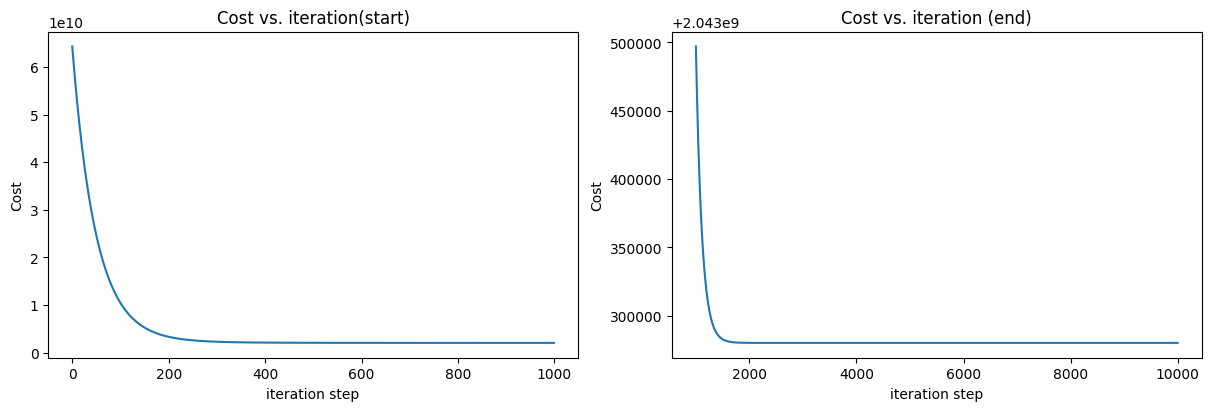

In [75]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(cost_hist[:1000]) #前100次迭代
ax2.plot(1000 + np.arange(len(cost_hist[1000:])), cost_hist[1000:]) # 1000次之后的迭代
ax1.set_title("Cost vs. iteration(start)");  
ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  
ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  
ax2.set_xlabel('iteration step') 
plt.show()

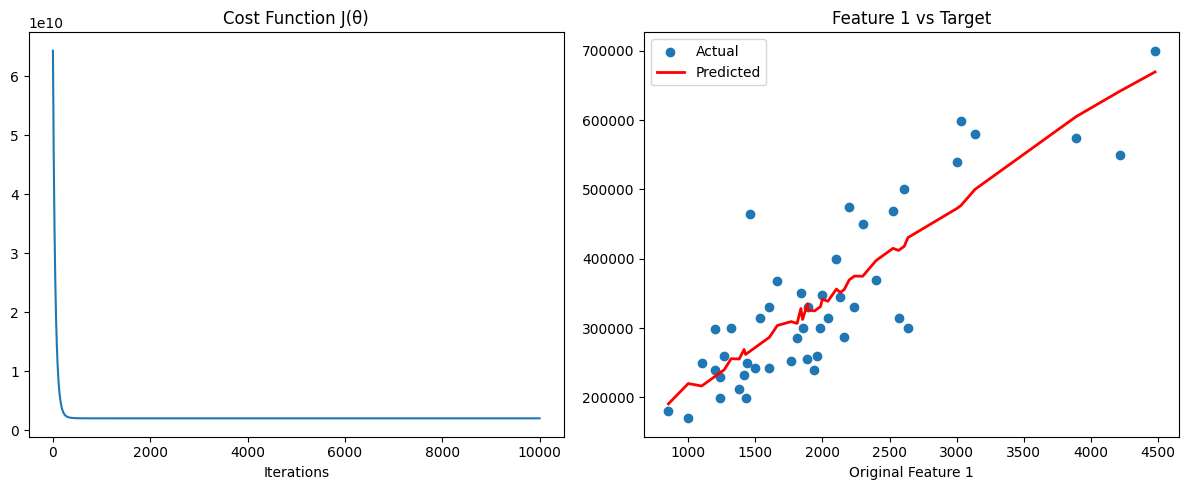

In [76]:
# 9. 可视化（取第一特征展示）
plt.figure(figsize=(12,5))

# 成本函数曲线
plt.subplot(1,2,1)
plt.plot(cost_hist)
plt.title("Cost Function J(θ)")
plt.xlabel("Iterations")

# 预测结果（使用原始数据的第一特征）
plt.subplot(1,2,2)

# plt.scatter(X[:,0], y, alpha=0.6, label="Actual")
# plt.plot(X[:,0], X_b @ theta_final, 'r', lw=2, label="Predicted")

sorted_idx = X[:,0].argsort()
plt.scatter(X[sorted_idx,0], y[sorted_idx], label="Actual")
plt.plot(X[sorted_idx,0], f_wb[sorted_idx], 'r', lw=2, label="Predicted")

plt.title("Feature 1 vs Target")
plt.xlabel("Original Feature 1")
plt.legend()

plt.tight_layout()
plt.show()

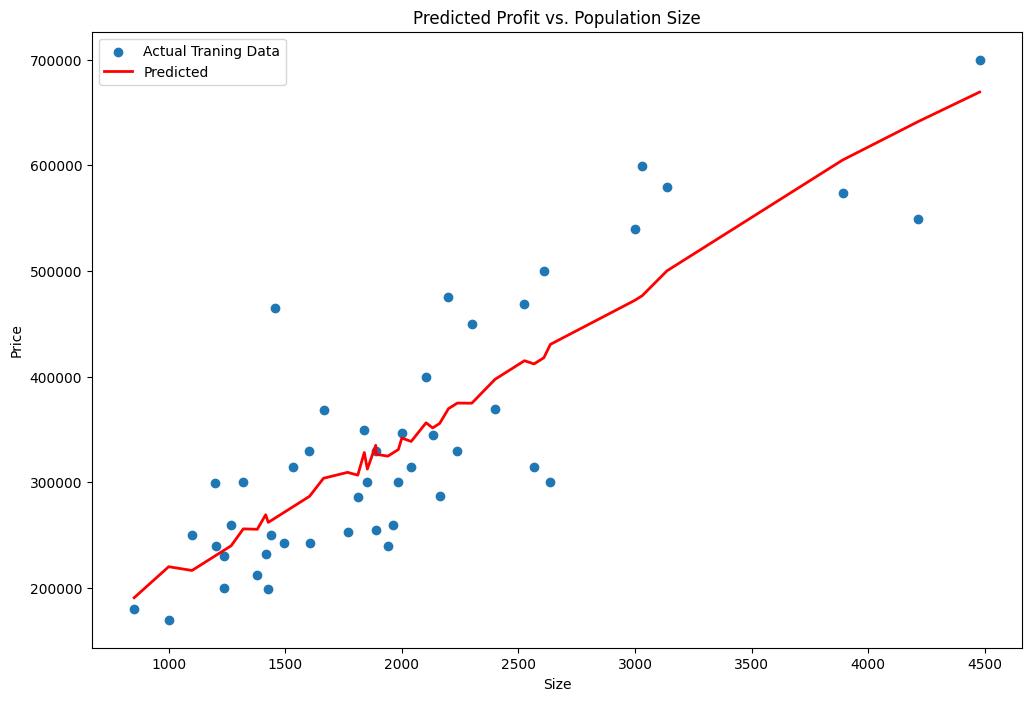

In [77]:
fig, ax = plt.subplots(figsize=(12,8))

sorted_idx = X[:,0].argsort()
ax.scatter(X[sorted_idx,0], y[sorted_idx], label="Actual Traning Data")
ax.plot(X[sorted_idx,0], f_wb[sorted_idx], 'r', lw=2, label="Predicted")

ax.legend(loc=2)
ax.set_xlabel('Size')
ax.set_ylabel('Price')
ax.set_title('Predicted Profit vs. Population Size')
plt.show()